# 1. Problem Description and Preparation

## 1.1 Problem Description
Given a grayscale topographic map of a part of Mars and some features of the land rover.

Assume that:

+ The land rover knows the starting point and the ending point, it has also an elevation map in which the height is represented by 254 pixels (2 for the deepest position and 255 for the highest position) and the sensors to know where it is. $(1)$

+ The land rover can move in only 4 directions: forward, backward, left and right, it can go up or down with an inclination of $\theta \leq 10^{\circ}$ (this value can be computed by the formula: $tan(\theta) = \dfrac{|h_1 - h_2|}{dist(P_1, P_2)}$ which is the ratio between the altitude difference of $P_1$ and $P_2$ and their real distance ($P_1$ and $P_2$ are 2 consecutive positions, therefore ${dist(P_1, P_2)} = const$). $(2)$

We need to find the shortest path (if it exists) for the land rover to travel between 2 points from the starting point A and the ending point B. The goal is the destination point B.

## 1.2 Preparation

**Importing the topography map image from the Internet**

In [1]:
file_name = "Mars_MGS_MOLA_DEM.jpg"

In [2]:
# DON'T RUN THIS CELL IF YOU ALREADY HAVE THE IMAGE
import requests #Module for getting image from the Internet
response = requests.get("http://planetpixelemporium.com/download/download.php?5672/mars_12k_topo.jpg")

with open(file_name, "wb") as file: #Create a file with the name above and save the content of response to it
    file.write(response.content)

**Importing relevant modules**

In [3]:
from PIL import Image # work with images
import matplotlib.pyplot as plt # work with graph
import numpy as np # work with arrays
import time # for analysis process
import queue # queue data structure
import pickle # for saving object
import os 
import pygame

pygame 2.0.1 (SDL 2.0.14, Python 3.9.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


This is Mars Orbiter Laser Altimeter **(MOLA)** map of Mars. According to NASA, "MOLA is an instrument on the Mars Global Surveyor (MGS), a spacecraft that was launched on November 7, 1996. The mission of MGS was to orbit Mars, and map it over the course of approximately 3 years, which it did sucessfully, completing 4 1/2 years of mapping." 

In [4]:
img = Image.open(file_name) #Open our saved file above

**Image description**

As we can see in the image, the darker region means that the region is deeper, the lighter areas mean higher altitude.

In [5]:
print("Shape of original image: ", np.asarray(img).shape)
img = img.convert("L") #Convert to one channel grey image
img_array = np.asarray(img)  #Convert the image to an array
img_array = img_array.astype('int32')
print("Shape of converted image: ", img_array.shape)
print("Image_array[0:2]: ", *img_array[0:2]) 
print()

Shape of original image:  (6144, 12288)
Shape of converted image:  (6144, 12288)
Image_array[0:2]:  [56 56 56 ... 56 56 56] [56 56 56 ... 56 56 56]



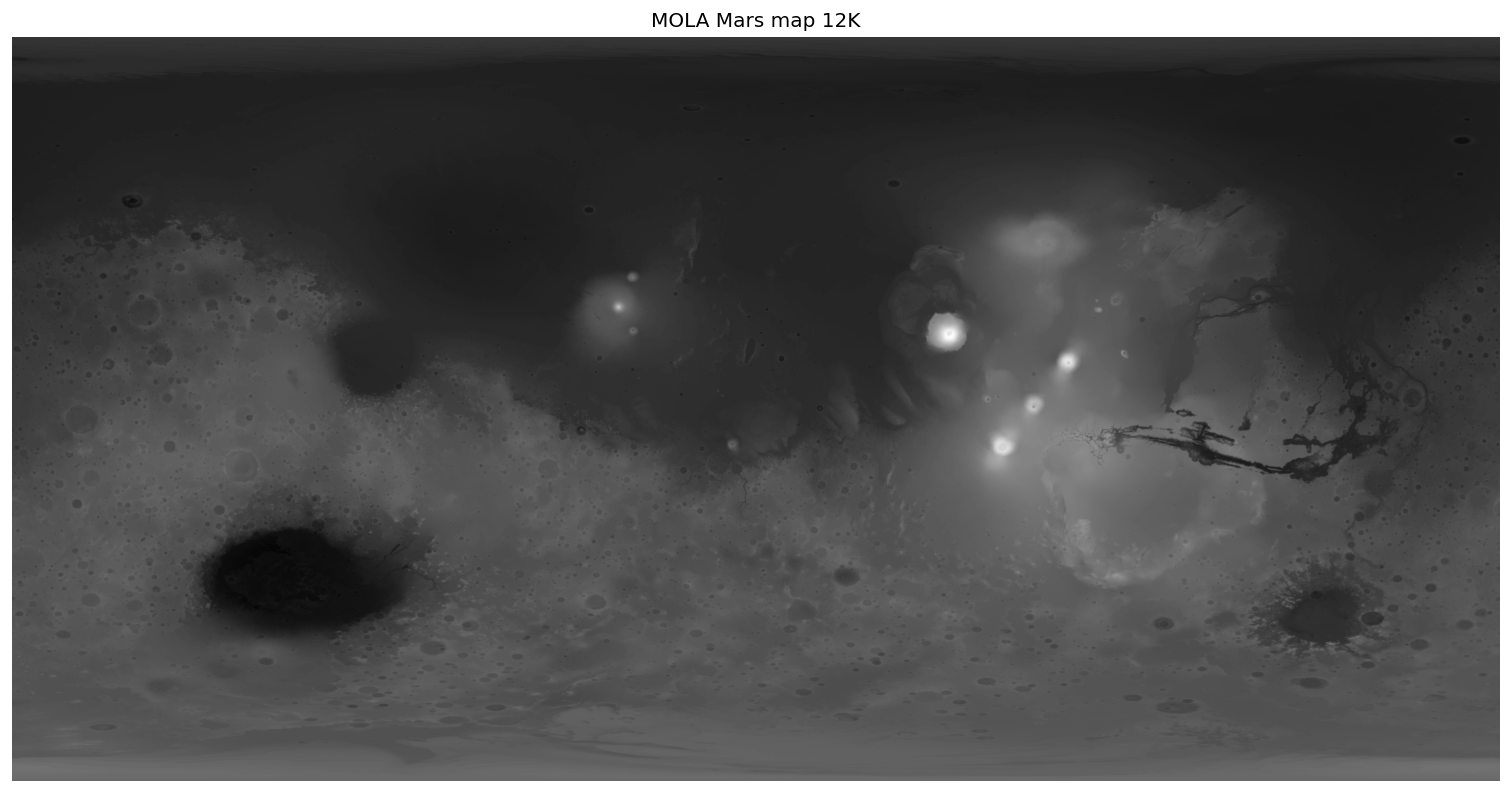

In [6]:
plt.figure(figsize = (16,9), dpi = 120) #Figure setting for plotting
plt.axis('off') #Turn off axis
plt.imshow(img_array, cmap = 'gray') #Show the gray figure
plt.title("MOLA Mars map 12K")
plt.show()

**Mars information:**

According to NASA, the maximum altitude is 21229 m (peak of Olympus Mons) and the minimum altitude is -8200m (Hellas Impact Crater). 

The pixel resolution of this map is 1736.25 meters per pixel (m). So $dist(P_1,P_2) = const = 1736.25 (m)$ ($P_1$ and $P_2$ are 2 consecutive positions).

**Topography map information:**

According to https://homepages.inf.ed.ac.uk/rbf/HIPR2/value.htm, we need to note that for a grayscale image, the pixel value is a single number that represents the brightness of the pixel. The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of possible values from 0 to 255. Typically zero is taken to be black, and 255 is taken to be white.

For this particular MOLA Mars map image above, we found that the maximum height (which is equivalent to the peak of Olympus Mons) is represented by a pixel value of 255 and the minimum height (which is equivalent to the Hellas Impact Crater) is represented by a pixel value of 2 (this is the reason why in part $(1)$ of the problem description, we assume that 2 is the pixel value representing for the deepest position and 255 for the highest position)

Therefore, each value pixel represents for: $\dfrac{1}{255 - 2 + 1} \times (max_{height} - min_{height}) = \dfrac{1}{254} \times (21229 + 8200) = 115.86$ meters of height.

**Random picking:**
+ The starting point
+ The destination

Starting point:  (6445, 1738) Ending point:  (4966, 1669)



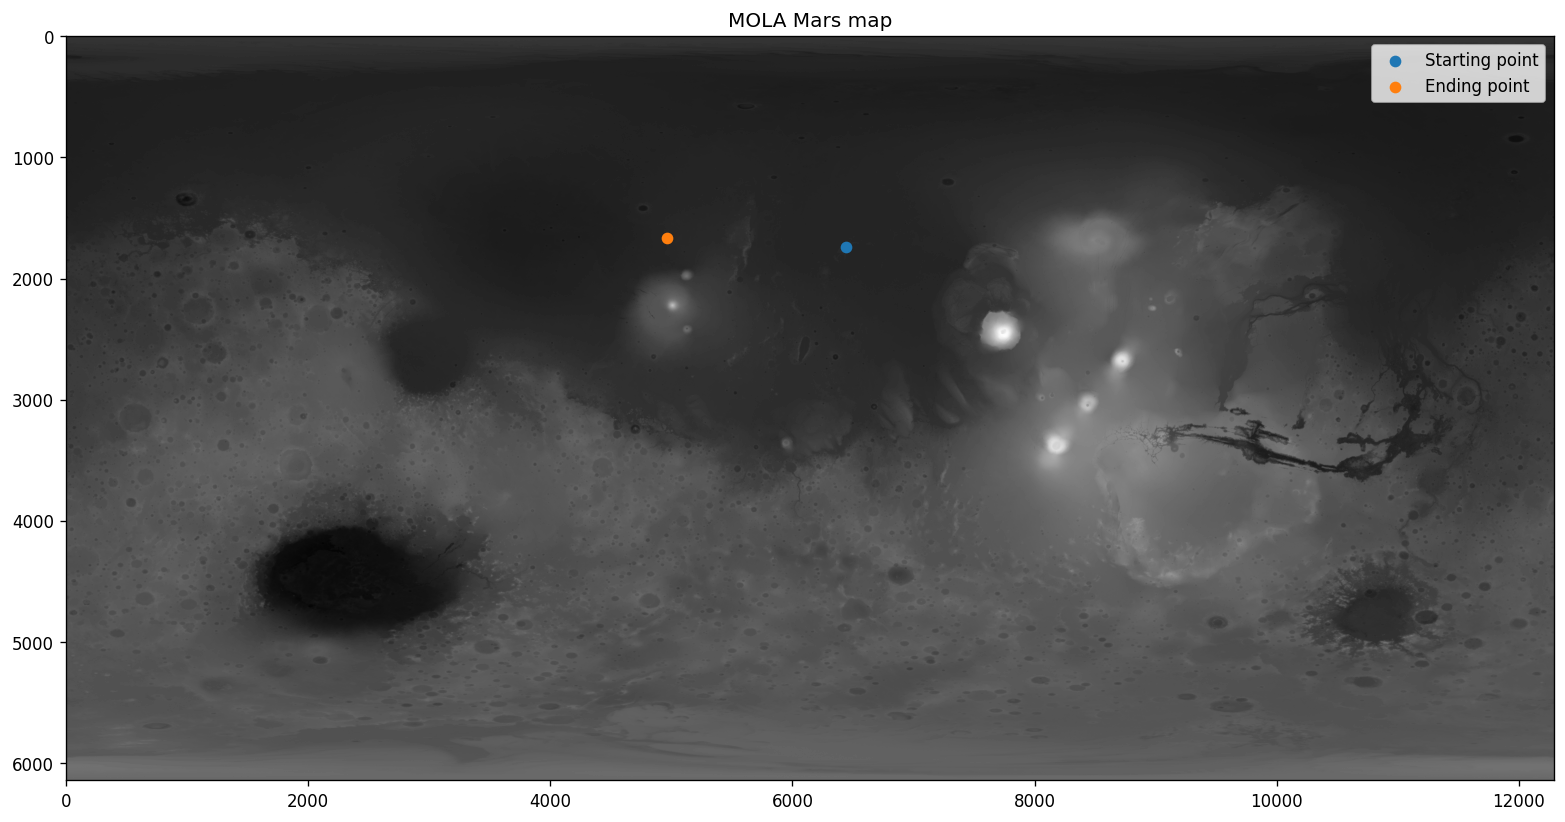

In [7]:
start = (np.random.randint(12288), np.random.randint(6144))
end = (np.random.randint(12288), np.random.randint(6144))
print("Starting point: ", start, "Ending point: ", end)
print()
plt.figure(figsize = (16,9), dpi = 120) #Figure setting for plotting
plt.imshow(img_array, cmap = 'gray') #Show the gray figure
plt.scatter(*start) #Plot the starting point
plt.scatter(*end) #Plot the ending point
plt.title("MOLA Mars map")
plt.legend(["Starting point", "Ending point"])
plt.show()

We need to find the shortest path (if it exists) for the land rover to travel between 2 points from the starting point A and the ending point B, but our path needs to satisfy $(2)$. Let's take an example of 2 consecutive points that our land rover can't move between them.

Take 2 points $P_1$ and $P_2$ next to each other:

+ P1: img_array[2000,5085] = 75
+ P2: img_array[2000,5086] = 78

Since the difference between the pixel value of these 2 points is 3, so in reality, the difference between the elevation of these 2 points is $3 \times 115.86 = 347.58 (m)$. Others, because $dist(P_1,P_2) = const = 1736.25 (m)$. Therefore $\theta = arctan\left(\dfrac{347.58}{1736.25}\right) = 11.32 ^{\circ} > 10 ^{\circ}$. In conclusion, the land rover can't go from $P_1$ to $P_2$ or vice versa.

# 2. Analysis Plan

In order to solve this problem, we consider:

+ 3 algorithms (1 uninformed search algorithms and 2 informed search algorithms): Uniform cost search, A* search, Greedy best first search.

+ 2 data structures with different sort algorithms for frontier: Priority queue (with heap sort) and List (with timsort)

+ 2 approaches for finding the neighbors of each point: Create the list of neighborhood for each node first and put it in an array before running the algorithm; Check the available neighbors for each node while running the algorithm.

+ 5 types of heuristics: using Manhattan distance; Euclidean distance; Octile distance; Tie-Breaking Low g-cost; Tie-Breaking High g-cost.

Others, since the original image has a very big size $(6144 \times 12288)$, therefore we consider only the part of this image with different size $15 \times 15, 20 \times 20, 25 \times 25, 30 \times 30)$.

We hypothesize also that the running time of each algorithm depends also on the standard deviation of pixel value for each value, therefore we need to divide the original image into many small images belonging to each bin of standard deviation!

In [8]:
# img_size = [15, 20, 25, 30, 50, 75, 100] # All the image size that we consider

# Just for visualization of this Jupyter Notebook, the running time of 
# the next cells below are too slow if we take all the size of the images
img_size = [25,50]

# 3. Data Preparation

In [9]:
x_max, y_max = img_array.shape
print("x_max: {}, y_max: {}".format(x_max, y_max))

x_max: 6144, y_max: 12288


In [10]:
%%time 

# Arrays[size] stores the data of images having specific size
arrays = {}

# We show only the case where img_size = 15, for the remaining cases, we do 
# the same analysis as below and we got the similar results
size = img_size[1] 

# Create a list for storing a tuple of image and its standard deviation (section, np.std(section))
arrays[size] = []

# Generate data
for i in range(0, x_max - size + 1, size//5): # Step = size//5
    for j in range(0, y_max - size + 1, size//5): # Step = size//5
        section = img_array[i:i + size, j:j + size] # Take the section of image
        arrays[size].append((section, np.std(section))) # Append (section, standard_deviation(section)) to arrays[size]

#Sort the image sections according to the standard deviation
arrays[size] = sorted(arrays[size], key = lambda tup: tup[1])

Wall time: 24.8 s


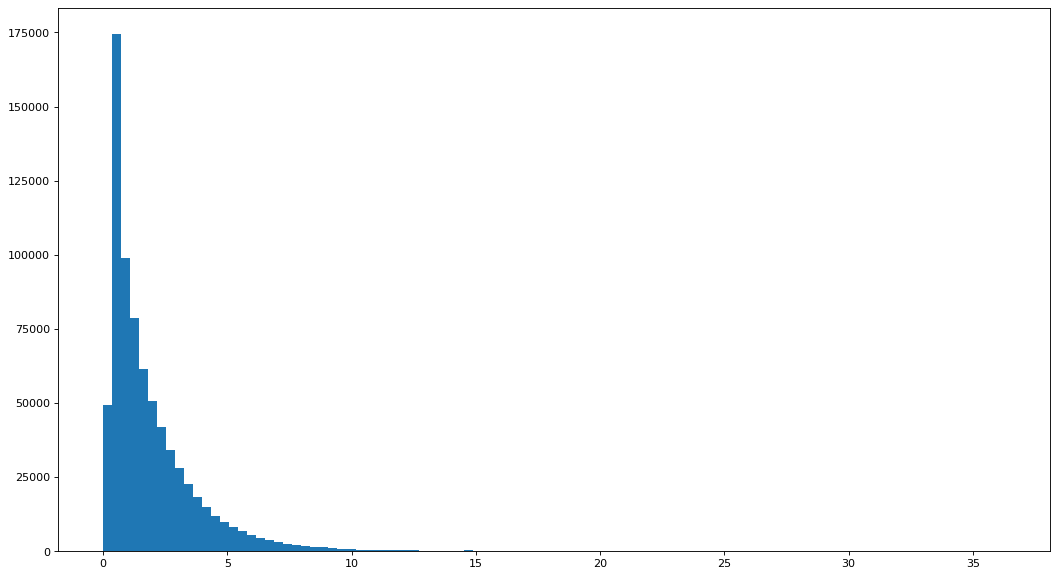

Wall time: 448 ms


In [11]:
%%time
# Store all the standard deviations to std_data
std_data = np.array([x[1] for x in arrays[size]])

# Plot all the data in std_data
plt.figure(figsize = (16, 9), dpi = 80)
plt.hist(std_data, bins = 100)
plt.show()

For images of size $15$, we can see that the standard deviation of each small images is near by 0. Let's consider only the case where the standard deviation of an image is less than $8$.

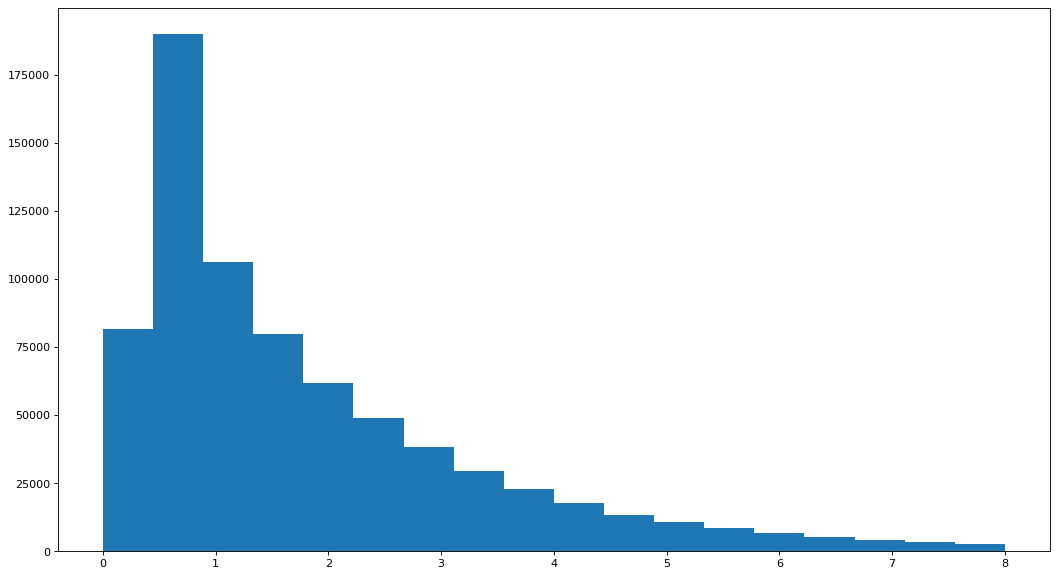

Wall time: 394 ms


In [12]:
%%time
# Crop the std_data and save it to std_data_crop, we just consider the case where the standard deviation which is less than 8
std_data_crop = np.array([x for x in std_data if x < 8])

# Plot all the data in std_data
plt.figure(figsize = (16, 9), dpi = 80)
plt.hist(std_data_crop, bins = 18)
plt.show()

From the histogram above, we can see that, most standard deviations are between $0$ and $1$. In order to discover the effect of standard deviations on the algorithm running time, we take the data in the first $16$ bins (each bin has size $0.5$).

# 4. Analysis

3 algorithms (1 uninformed search algorithms and 2 informed search algorithms): Uniform cost search, A* search, Greedy best first search.

2 data structures with different sort algorithms for frontier: Priority queue (with heap sort) and List (with timsort)

2 approaches for finding the neighbors of each point: Create the list of neighborhood for each node first and put it in an array before running the algorithm; Check the available neighbors for each node while running the algorithm.

5 types of heuristics: using Manhattan distance; Tie-Breaking High g-cost, Variance of Tie-Breaking High g-cost, Tie-Breaking Low g-cost, Variance of Tie-Breaking Low g-cost.

## 4.1 Preparation

Get the data
+ For $img_{size} = 15$, we consider only the case where the standard deviation of an image is less than $8$ and we choose also the first 16 bins of size 0.5.

+ For $img_{size} = 20$, we consider only the case where the standard deviation of an image is less than $8$ and we choose also the first 16 bins of size 0.5.

+ For $img_{size} = 25$, we consider only the case where the standard deviation of an image is less than $8$ and we choose also the first 16 bins of size 0.5.

+ For $img_{size} = 30$, we consider only the case where the standard deviation of an image is less than $8$ and we choose also the first 16 bins of size 0.5.

+ For $img_{size} = 50$, we consider only the case where the standard deviation of an image is less than $8$ and we choose also the first 16 bins of size 0.5.

+ For $img_{size} = 75$, we consider only the case where the standard deviation of an image is less than $8$ and we choose also the first 16 bins of size 0.5.

+ For $img_{size} = 100$, we consider only the case where the standard deviation of an image is less than $8$ and we choose also the first 16 bins of size 0.5.

In [13]:
%%time
import random 

#Variables
arrays = {}
data = {}

#Bin information
num_bins = 16
bin_size = 0.5

for size in img_size:
    arrays[size] = []
    for i in range(0, x_max - size + 1, size//5):
        for j in range(0, y_max - size + 1, size//5):
            section = img_array[i:i + size, j:j + size]
            arrays[size].append((section, np.std(section)))

for size in img_size:
    tmp_data = {}
    
    i = bin_size
    
    while i <= num_bins * bin_size:
        
        #Standard deviation filtering
        tmp_data[(i-bin_size,i)] = [arr[0] for arr in arrays[size] if arr[1] < i] 
        
        #Randomize our data before writing it to a txt file
        random.shuffle(tmp_data[(i-bin_size,i)]) 
        
        #Save only 100 random images for analysis process
        tmp_data[(i-bin_size,i)] = tmp_data[(i-bin_size,i)][0:1] # Take only 1 image for fast video capture  
        
        i += bin_size
    
    data[size] = tmp_data

Wall time: 2min 10s


Path for storing analysis result

In [14]:
path = "Analysis Results"

# Make folder if path does not exist
if os.path.exists(path) == False:
    os.mkdir(path)

**Heuristic Functions**

In [15]:
# Manhattan distance
def manhattan(actual_node, start_node ,goal_node, delta=0.01):
    actualPos = actual_node.position
    endPos = goal_node.position
    return abs(actualPos[0] - endPos[0]) + abs(actualPos[1] - endPos[1])

# There are many states with the same f-cost, and we have to choose the order in which to expand them. 
# For tie_breaking_high_g_cost, we preferred states closer to the goal node than the goal state.
def tie_breaking_high_g_cost(actual_node, start_node, goal_node, delta = 0.001):
    actualPos = actual_node.position
    endPos = goal_node.position
    return manhattan(actual_node, start_node, goal_node) * (1 + delta)

# Variance of tie breaking high g-cost, we vary the value of delta in tie_breaking_high_g_cost, according
# to the position of the actual node
def var_tie_breaking_high_g_cost(actual_node, start_node, goal_node, delta = 0.001):
    actualPos = actual_node.position
    endPos = goal_node.position
    rate1 = manhattan(actual_node, start_node, goal_node)
    rate2 = manhattan(start_node, start_node, goal_node)
    return rate1 * (1 + delta* (0.5 + rate1/rate2))

# There are many states with the same f-cost, and we have to choose the order in which to expand them. 
# For tie_breaking_low_g_cost, we preferred states closer to the start node than the goal state.
def tie_breaking_low_g_cost(actual_node, start_node, goal_node, delta = 0.001):
    actualPos = actual_node.position
    endPos = goal_node.position
    return manhattan(actual_node, start_node, goal_node) * (1 - delta)

# Variance of tie breaking low g-cost, we vary the value of delta in tie_breaking_low_g_cost, according
# to the position of the actual node
def var_tie_breaking_low_g_cost(actual_node, start_node, goal_node, delta = 0.001):
    actualPos = actual_node.position
    endPos = goal_node.position
    rate1 = manhattan(actual_node, start_node, goal_node)
    rate2 = manhattan(start_node, start_node, goal_node)
    return rate1 * (1 + delta * (1.5 - rate1/rate2))

# Heuristics dictionary containing all kinds of heuristic functions
heuristics = {
    'manhattan': manhattan,
    'tie_breaking_high_g_cost': tie_breaking_high_g_cost,
    'var_tie_breaking_high_g_cost': var_tie_breaking_high_g_cost,
    'tie_breaking_low_g_cost': tie_breaking_low_g_cost,
    'var_tie_breaking_low_g_cost': var_tie_breaking_low_g_cost
}

**Node definition, Analysis object, Methods of finding neighbors, Data initialization**

In [16]:
#------------------------------------------ Node definition -----------------------------------------
class Node():
    # Node initialization
    def __init__(self, position):
        self.position = position # Tuple (x,y)
        self.g = 0 # g-cost
        self.h = 0 # h-cost
        self.f = None # f-cost
        self.parent = None # Parent node
    
    # Print the node
    def __str__(self): 
        return str(self.position)
    
    # Equality of 2 nodes (position)
    def __eq__(self, other):
        return self.position == other.position
    
    # Less than
    def __lt__(self, other):
        return self.f < other.f
    
    # Greater than
    def __gt__(self, other):
        return self.f > other.f


#-------------------------------------- Analysis initialization -------------------------------------
# Define the class containing our analysis results
class AnalysisResults:
    def __init__(self, size):
        self.size = size # Size of image
        
        # Dictionary of average run time and average steps_count, for example: 
        # avg_run_time[(0,0.5)] returns the average run time of image inside the 
        # bin of standard deviation from 0 to 0.5
        self.avg_run_time = {}
        self.avg_steps_count = {}
        
        
#----------------------------------------- Finding neighbors ----------------------------------------
# Finding while runing
def next_pos_list(array, actual_node, img_shape, theta):
    '''
    array: array of height value
    actual_node: node object of the actual node that you want to find its neighbors
    img_shape: tuple(x_size, y_size) - size of the image
    theta: maximum distance of heigh between 2 consecutive positions
    '''
    res = []
    x_size, y_size = img_shape
    actualPos = actual_node.position
    actual_nodeValue = array[actualPos[0]][actualPos[1]]
    
    # Conditions checking for neighbors
    if actualPos[0] + 1 < x_size and abs(actual_nodeValue - array[actualPos[0] + 1][actualPos[1]]) <= theta:
        res.append((actualPos[0] + 1, actualPos[1]))
    if actualPos[1] + 1 < y_size and abs(actual_nodeValue - array[actualPos[0]][actualPos[1] + 1]) <= theta:
        res.append((actualPos[0], actualPos[1] + 1))
    if actualPos[0] - 1 >= 0 and abs(actual_nodeValue - array[actualPos[0] - 1][actualPos[1]]) <= theta:
        res.append((actualPos[0] - 1, actualPos[1]))
    if actualPos[1] - 1 >= 0 and abs(actual_nodeValue - array[actualPos[0]][actualPos[1] - 1]) <= theta:
        res.append((actualPos[0], actualPos[1] - 1))
    
    return res
       
    
# Find neighbors first before run
def make_grid(array, img_shape, theta):
    '''
    array: array of height value
    img_shape: tuple(x_size, y_size) - size of the image
    theta: maximum distance of heigh between 2 consecutive positions
    '''
    grid = [[None for j in range(len(array))] for i in range(len(array))]
    x_size, y_size = img_shape

    for i in range(len(array)):
        for j in range(len(array)):
            res = []
            actual_nodeValue = int(array[i][j])  
            
            # Conditions checking for neighbors
            if i + 1 < x_size and abs(actual_nodeValue - int(array[i + 1][j])) <= theta:
                res.append((i + 1,j))
            if j + 1 < y_size and abs(actual_nodeValue - int(array[i][j + 1])) <= theta:
                res.append((i,j + 1))
            if i - 1 >= 0 and abs(actual_nodeValue - int(array[i - 1][j])) <= theta:
                res.append((i - 1,j))
            if j - 1 >= 0 and abs(actual_nodeValue - int(array[i][j - 1])) <= theta:
                res.append((i,j - 1))
            grid[i][j] = res # grid[i][j] contains a list of points which can be the neighbors of the point at position (i,j)
    
    return grid

#----------------------------------------- Data initialization ----------------------------------------
# Random the position of node
def init(size):
    start_node = (np.random.randint(0,size), np.random.randint(0,size))
    goal_node = (np.random.randint(0,size), np.random.randint(0,size))
    return start_node, goal_node

# Create a list of n pairs of nodes
def random_initialization(n, size):
    return [init(size) for i in range(n)]

### 4.1.1 Astar analysis function

In [17]:
def Astar_analysis(data, parameters):        
    #-------------------------------------- 3 different A* algorithms --------------------------------------
    
    # Using list (with timsort) for frontier, finding neighbors while running
    def norm_Astar_list(img_array, start_node, goal_node, img_shape, theta, heuristic):
        
        steps_count = 0 # Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = [start_node] # Add the start_node to the frontier

        while len(frontier) > 0: # While there is something inside the frontier, continue the algorithm
            
            # Sort the frontier in reverse order, here Python uses timsort
            frontier = sorted(frontier, reverse = True)
            
            # Pop the last node, which has the lowest value of f
            actual_node = frontier.pop()
            
            # Add 1 to steps_count for each time we enter a node
            steps_count += 1 
            
            # Save the temporary g-score of the actual node
            tmp_g_score = actual_node.g
            
            # Return the steps_count for analysis process
            if actual_node == goal_node:
                return steps_count
            
            # Add the position (tuple(x,y)) to visited_node
            visited_nodes.add(actual_node.position)
            
            # Create a list of temporary visited nodes, add these nodes to the frontier after the for loop below 
            tmp_visited_nodes = []
            
            # Iterate over all neighbors of the actual node
            for next_pos in next_pos_list(img_array, actual_node, img_shape, theta):
                steps_count += 1 # Add 1 for each time we check the next node
                next_node = Node(next_pos) # Create next_node with position next_pos
                
                # If next_pos in visited_nodes, we don't do anything
                if next_pos not in visited_nodes:

                    #f = h + g, update f-score
                    next_node.g = tmp_g_score + 1
                    next_node.h = heuristic(next_node, start_node, goal_node, delta) 
                    next_node.f = next_node.h + next_node.g
                    next_node.parent = actual_node
                    
                    # If next_node in frontier
                    if next_node in frontier:
                        idx = frontier.index(next_node) # Find the index of next_node in the frontier
                        
                        # If the f-score of the duplicate node is more than that of the actual next_node
                        if frontier[idx] > next_node: 
                            frontier.remove(next_node) # Remove this next_node in the frontier
                            tmp_visited_nodes.append(next_node) # And append the actual next_node to the frontier
                    else:
                        tmp_visited_nodes.append(next_node) # Append the actual next_node to the frontier
            
            # Add all the nodes inside tmp_visited_nodes into frontier
            frontier += tmp_visited_nodes
        
        # Return the number of steps counted for analysis process
        return steps_count
    
    
    # Using priority queue (with heapsort) for frontier, finding neighbors while running
    def norm_Astar_priority_queue(img_array, start_node, goal_node, img_shape, theta, heuristic):
        steps_count = 0 # Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = queue.PriorityQueue()
        frontier.put((0, start_node))

        while frontier.empty() == False:
            actual_node = frontier.get()[1]        
            steps_count += 1 # Add 1 for each time we enter a node
            tmp_g_score = actual_node.g

            if actual_node == goal_node:
                return steps_count

            visited_nodes.add(actual_node.position)

            # Iterate over all neighbors of the actual node
            for next_pos in next_pos_list(img_array, actual_node, img_shape, theta):
                steps_count += 1 # Add 1 for each time we check the next node
                next_node = Node(next_pos) # Create next_node with position next_pos
                
                # If next_pos in visited_nodes, we don't do anything
                if next_pos not in visited_nodes:

                    # f = h + g
                    next_node.g = tmp_g_score + 1
                    next_node.h = heuristic(next_node, start_node, goal_node, delta) 
                    next_node.f = next_node.h + next_node.g
                    next_node.parent = actual_node

                    # Check if there exists a node having the same position as next_node (denoted as duplicate node) 
                    # in the frontier or not
                    if (next_node.f, next_node) in frontier.queue:
                        # Find the index of the duplicate node in the frontier.queue
                        idx = frontier.queue.index((next_node.f, next_node)) 

                        # Check the f-value of the 2 nodes (next_node and the duplicate node in the frontier)
                        if frontier.queue[idx][0] > next_node.f:
                            
                            # Replace the duplicate node by the next_node with lower f-score
                            # Step 1: Create a temporary queue
                            tmp_queue = queue.PriorityQueue()
                            
                            # Step 2: Put all the elements of the frontier to tmp_queue until we find the duplicate node
                            while t != frontier.queue[idx]:
                                t = frontier.get()
                                tmp_queue.put(t)
                            
                            # Step 3: Delete the duplicate node
                            t = frontier.get()
                            
                            # Step 4: Reput all the elements from the tmp_queue to the frontier
                            while tmp.empty() == False:
                                t = tmp_queue.get()
                                frontier.put(t)    
                                
                            frontier.put((next_node.f, next_node)) # Put next_node to frontier
                    else:
                        frontier.put((next_node.f, next_node)) # Put next_node to frontier
        
        # Return the number of steps counted for analysis process
        return steps_count
    
    
     # Using list (with timsort) for frontier, finding neighbors before running
    def Astar_list_with_init(grid, img_array, start_node, goal_node, img_shape, theta, heuristic):    
        steps_count = 0 # Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = [start_node] # Add the start_node to the frontier

        while len(frontier) > 0: # While there is something inside the frontier, continue the algorithm
            
            # Sort the frontier in reverse order, here Python uses timsort
            frontier = sorted(frontier, reverse = True)
            
            # Pop the last node, which has the lowest value of f
            actual_node = frontier.pop()
            
            # Add 1 to steps_count for each time we enter a node
            steps_count += 1 
            
            # Save the temporary g-score of the actual node
            tmp_g_score = actual_node.g
            
            # Return the steps_count for analysis process
            if actual_node == goal_node:
                return steps_count
            
            # Add the position (tuple(x,y)) to visited_node
            visited_nodes.add(actual_node.position)
            
            # Create a list of temporary visited nodes, add these nodes to the frontier after the for loop below 
            tmp_visited_nodes = []

            # Iterate over all neighbors of the actual node
            for next_pos in grid[actual_node.position[0]][actual_node.position[1]]:
                steps_count += 1 # Add 1 for each time we check the next node
                next_node = Node(next_pos) # Create next_node with position next_pos
                
                # If next_pos in visited_nodes, we don't do anything
                if next_pos not in visited_nodes:

                    #f = h + g, update f-score
                    next_node.g = tmp_g_score + 1
                    next_node.h = heuristic(next_node, start_node, goal_node, delta) 
                    next_node.f = next_node.h + next_node.g
                    next_node.parent = actual_node

                    # If next_node in frontier
                    if next_node in frontier:
                        idx = frontier.index(next_node) # Find the index of next_node in the frontier
                        
                        # If the f-score of the duplicate node is more than that of the actual next_node
                        if frontier[idx] > next_node: 
                            frontier.remove(next_node) # Remove this next_node in the frontier
                            tmp_visited_nodes.append(next_node) # And append the actual next_node to the frontier
                    else:
                        tmp_visited_nodes.append(next_node) # Append the actual next_node to the frontier
            
            # Add all the nodes inside tmp_visited_nodes into frontier
            frontier += tmp_visited_nodes
        
        # Return the number of steps counted for analysis process
        return steps_count    
    
    #------------------------------------ Retrieving data from parameters ------------------------------------
    
    #List of image size:
    img_size = parameters['img_size']
    
    #Type of frontier (list or priority_queue)
    frontier_type = parameters['frontier_type']    
    
    #Type of finding neighbors (find_first_before_run or find_while_running)
    finding_neighbors = parameters['finding_neighbors']
    
    #Choose Astar version
    if finding_neighbors == 'find_while_running' and frontier_type == 'list':
        Astar = norm_Astar_list 
    elif finding_neighbors == 'find_while_running' and frontier_type == 'priority_queue':
        Astar = norm_Astar_priority_queue
    elif finding_neighbors == 'find_first_before_run' and frontier_type == 'list':
        Astar = Astar_list_with_init
    
    #Type of heuristic function (manhattan; tie_breaking_high_g_cost)
    global heuristics
    heuristic_type = parameters['heuristic_type'] 
    heuristic = heuristics[heuristic_type]
    
    #Delta for heuristic functions
    delta = 0.001
    if 'delta' in parameters.keys():
        delta = parameters['delta']

    #Number of random starting points and ending points to run analysis
    num_points = parameters['num_points'] 
    
    
    #-------------------------------------------- Analysis process --------------------------------------------
    # Store the analysis results
    analysis_results = []
    
    # Iterate over all the image size in data.keys()
    for size in data.keys():
        
        # Preparation
        analysis_results.append(AnalysisResults(size)) # Create a new AnalysisResults object and append it to the list
        pair_node_list = random_initialization(num_points, size) # Create a random pair of start node and goal node
        print("Image size: {}".format(size))

        # Run the analysis for loop
        for data_bin_key in data[size].keys():
                
            i = 1
            total_time = 0
            total_steps_count = 0
            num_images = len(data[size][data_bin_key])

            for start_node, goal_node in pair_node_list:
                
                # Create start_node and goal_node objects
                start_node = Node(start_node)
                goal_node = Node(goal_node)

                # Iterate over all image in data[size][data_bin_key], for example if we want to access to the list of
                # images of size 15 inside the data_bin (0,0.5) -> data[15][(0,0.5)]
                for tmp_data in data[size][data_bin_key]:
                    
                    # Different type of analysis for each finding_neighbors algorithm
                    if finding_neighbors ==  'find_first_before_run':
                        grid = make_grid(tmp_data, (size, size), 2) # Make grid of neighbors first before run the algorithm
                        start_time = time.time() 
                        steps_count = Astar(grid, tmp_data, start_node, goal_node, (size, size), 2, heuristic)
                        running_time = time.time() - start_time # Running time 
                    else:
                        start_time = time.time()
                        steps_count = Astar(tmp_data, start_node, goal_node, (size, size), 2, heuristic)
                        running_time = time.time() - start_time # Running time             
                    
                    total_time += running_time
                    total_steps_count += steps_count
                    
            print("Standard deviation range: {}".format(data_bin_key))
            
            # Average running time
            tmp_avg_run_time = total_time / num_images / num_points
            analysis_results[-1].avg_run_time[data_bin_key] = tmp_avg_run_time
            print("Average running time: {} s.".format(tmp_avg_run_time))

            # Average steps count
            tmp_avg_steps_count = total_steps_count // num_images // num_points
            analysis_results[-1].avg_steps_count[data_bin_key] = tmp_avg_steps_count
            print("Average steps counts: {} steps.".format(tmp_avg_steps_count))
                                         
        print("------------------------------------")
                                         
    return analysis_results

### 4.1.2 Greedy BFS analysis function

In [18]:
def GreedyBFS_analysis(data, parameters):        
    #-------------------------------------- 4 different A* algorithms --------------------------------------
    
    def norm_GreedyBFS_list(img_array, start_node, goal_node, img_shape, theta, heuristic):
        steps_count = 0 # Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = [start_node] # Add the start_node to the frontier

        while len(frontier) > 0: # While there is something inside the frontier, continue the algorithm
            
            # Sort the frontier in reverse order, here Python uses timsort
            frontier = sorted(frontier, reverse = True)
            
            # Pop the last node, which has the lowest value of f
            actual_node = frontier.pop()
            
            # Add 1 to steps_count for each time we enter a node
            steps_count += 1 
            
            # Save the temporary g-score of the actual node
            tmp_g_score = actual_node.g
            
            # Return the steps_count for analysis process
            if actual_node == goal_node:
                return steps_count
            
            # Add the position (tuple(x,y)) to visited_node
            visited_nodes.add(actual_node.position)
            
            # Create a list of temporary visited nodes, add these nodes to the frontier after the for loop below 
            tmp_visited_nodes = []

            # Iterate over all neighbors of the actual node
            for next_pos in next_pos_list(img_array, actual_node, img_shape, theta):
                steps_count += 1 # Add 1 for each time we check the next node
                next_node = Node(next_pos) # Create next_node with position next_pos
                
                # If next_pos in visited_nodes, we don't do anything
                if next_pos not in visited_nodes:

                    #f = h + g, update f-score
                    next_node.h = heuristic(next_node, start_node, goal_node, delta) 
                    next_node.f = next_node.h
                    next_node.parent = actual_node

                    # If next_node in frontier
                    if next_node in frontier:
                        idx = frontier.index(next_node) # Find the index of next_node in the frontier
                        
                        # If the f-score of the duplicate node is more than that of the actual next_node
                        if frontier[idx] > next_node: 
                            frontier.remove(next_node) # Remove this next_node in the frontier
                            tmp_visited_nodes.append(next_node) # And append the actual next_node to the frontier
                    else:
                        tmp_visited_nodes.append(next_node) # Append the actual next_node to the frontier
            
            # Add all the nodes inside tmp_visited_nodes into frontier
            frontier += tmp_visited_nodes
        
        # Return the number of steps counted for analysis process
        return steps_count
    
    
    def norm_GreedyBFS_priority_queue(img_array, start_node, goal_node, img_shape, theta, heuristic):
        steps_count = 0 #Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = queue.PriorityQueue()
        frontier.put((0, start_node))

        while frontier.empty() == False:
            actual_node = frontier.get()[1]        
            steps_count += 1 # Add 1 for each time we enter a node
            
            # Save the temporary g-score of the actual node
            tmp_g_score = actual_node.g

            if actual_node == goal_node:
                return steps_count

            visited_nodes.add(actual_node.position)

            # Iterate over all neighbors of the actual node
            for next_pos in next_pos_list(img_array, actual_node, img_shape, theta):
                steps_count += 1 # Add 1 for each time we check the next node
                next_node = Node(next_pos) # Create next_node with position next_pos
                
                # If next_pos in visited_nodes, we don't do anything
                if next_pos not in visited_nodes:

                     #f = h + g
                    next_node.h = heuristic(next_node, start_node, goal_node, delta) 
                    next_node.f = next_node.h
                    next_node.parent = actual_node

                    # Check if there exists a node having the same position as next_node (denoted as duplicate node) 
                    # in the frontier or not
                    if (next_node.f, next_node) in frontier.queue:
                        # Find the index of the duplicate node in the frontier.queue
                        idx = frontier.queue.index((next_node.f, next_node)) 

                        # Check the f-value of the 2 nodes (next_node and the duplicate node in the frontier)
                        if frontier.queue[idx][0] > next_node.f:
                            
                            # Replace the duplicate node by the next_node with lower f-score
                            # Step 1: Create a temporary queue
                            tmp_queue = queue.PriorityQueue()
                            
                            # Step 2: Put all the elements of the frontier to tmp_queue until we find the duplicate node
                            while t != frontier.queue[idx]:
                                t = frontier.get()
                                tmp_queue.put(t)
                            
                            # Step 3: Delete the duplicate node
                            t = frontier.get()
                            
                            # Step 4: Reput all the elements from the tmp_queue to the frontier
                            while tmp.empty() == False:
                                t = tmp_queue.get()
                                frontier.put(t)    
                                
                            frontier.put((next_node.f, next_node)) # Put next_node to frontier
                    else:
                        frontier.put((next_node.f, next_node)) # Put next_node to frontier
        
        # Return the number of steps counted for analysis process
        return steps_count
    
    
    def GreedyBFS_list_with_init(grid, img_array, start_node, goal_node, img_shape, theta, heuristic):    
        steps_count = 0 #Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = [start_node] # Add the start_node to the frontier

        while len(frontier) > 0: # While there is something inside the frontier, continue the algorithm
            
            # Sort the frontier in reverse order, here Python uses timsort
            frontier = sorted(frontier, reverse = True)
            
            # Pop the last node, which has the lowest value of f
            actual_node = frontier.pop()
            
            # Add 1 to steps_count for each time we enter a node
            steps_count += 1 
            
            # Save the temporary g-score of the actual node
            tmp_g_score = actual_node.g
            
            # Return the steps_count for analysis process
            if actual_node == goal_node:
                return steps_count
            
            # Add the position (tuple(x,y)) to visited_node
            visited_nodes.add(actual_node.position)
            
            # Create a list of temporary visited nodes, add these nodes to the frontier after the for loop below 
            tmp_visited_nodes = []

            # Iterate over all neighbors of the actual node
            for next_pos in grid[actual_node.position[0]][actual_node.position[1]]:
                steps_count += 1 # Add 1 for each time we check the next node
                next_node = Node(next_pos) # Create next_node with position next_pos
                
                # If next_pos in visited_nodes, we don't do anything
                if next_pos not in visited_nodes:

                    #f = h + g, update f-score
                    next_node.h = heuristic(next_node, start_node, goal_node, delta) 
                    next_node.f = next_node.h
                    next_node.parent = actual_node

                    # If next_node in frontier
                    if next_node in frontier:
                        idx = frontier.index(next_node) # Find the index of next_node in the frontier
                        
                        # If the f-score of the duplicate node is more than that of the actual next_node
                        if frontier[idx] > next_node: 
                            frontier.remove(next_node) # Remove this next_node in the frontier
                            tmp_visited_nodes.append(next_node) # And append the actual next_node to the frontier
                    else:
                        tmp_visited_nodes.append(next_node) # Append the actual next_node to the frontier
            
            # Add all the nodes inside tmp_visited_nodes into frontier
            frontier += tmp_visited_nodes
        
        # Return the number of steps counted for analysis process
        return steps_count
    
    
    #------------------------------------ Retrieving data from parameters ------------------------------------
    
    #List of image size:
    img_size = parameters['img_size']
    
    #Type of frontier (list or priority_queue)
    frontier_type = parameters['frontier_type']    
    
    #Type of finding neighbors (find_first_before_run or find_while_running   finding_neighbors = parameters['finding_neighbors']
    finding_neighbors = parameters['finding_neighbors']
    
    #Choose GreedyBFS version
    if finding_neighbors == 'find_while_running' and frontier_type == 'list':
        GreedyBFS = norm_GreedyBFS_list 
    elif finding_neighbors == 'find_while_running' and frontier_type == 'priority_queue':
        GreedyBFS = norm_GreedyBFS_priority_queue
    elif finding_neighbors == 'find_first_before_run' and frontier_type == 'list':
        GreedyBFS = GreedyBFS_list_with_init
    
    #Type of heuristic function (manhattan; tie_breaking_high_g_cost)
    global heuristics
    heuristic_type = parameters['heuristic_type'] 
    heuristic = heuristics[heuristic_type]
    
    #Delta for heuristic functions
    delta = 0.001
    if 'delta' in parameters.keys():
        delta = parameters['delta']

    #Number of random starting points and ending points to run analysis
    num_points = parameters['num_points'] 
    
    #-------------------------------------------- Analysis process --------------------------------------------
    # Store the analysis results
    analysis_results = []
    
    # Iterate over all the image size in data.keys()
    for size in data.keys():
        
        # Preparation
        analysis_results.append(AnalysisResults(size)) # Create a new AnalysisResults object and append it to the list
        pair_node_list = random_initialization(num_points, size) # Create a random pair of start node and goal node
        print("Image size: {}".format(size))

        # Run the analysis for loop
        for data_bin_key in data[size].keys():
                
            i = 1
            total_time = 0
            total_steps_count = 0
            num_images = len(data[size][data_bin_key])

            for start_node, goal_node in pair_node_list:
                
                # Create start_node and goal_node objects
                start_node = Node(start_node)
                goal_node = Node(goal_node)

                # Iterate over all image in data[size][data_bin_key], for example if we want to access to the list of
                # images of size 15 inside the data_bin (0,0.5) -> data[15][(0,0.5)]
                for tmp_data in data[size][data_bin_key]:
                    
                    # Different type of analysis for each finding_neighbors algorithm
                    if finding_neighbors ==  'find_first_before_run': 
                        grid = make_grid(tmp_data, (size, size), 2) # Make grid of neighbors first before run the algorithm
                        start_time = time.time()
                        steps_count = GreedyBFS(grid, tmp_data, start_node, goal_node, (size, size), 2, heuristic)
                        running_time = time.time() - start_time # Running time
                    else:
                        start_time = time.time()
                        steps_count = GreedyBFS(tmp_data, start_node, goal_node, (size, size), 2, heuristic)
                        running_time = time.time() - start_time # Running time  
                    
                    total_time += running_time
                    total_steps_count += steps_count

            print("Standard deviation range: {}".format(data_bin_key))
            
            # Average running time
            tmp_avg_run_time = total_time / num_images / num_points
            analysis_results[-1].avg_run_time[data_bin_key] = tmp_avg_run_time
            print("Average running time: {} s.".format(tmp_avg_run_time))

            # Average steps count
            tmp_avg_steps_count = total_steps_count // num_images // num_points
            analysis_results[-1].avg_steps_count[data_bin_key] = tmp_avg_steps_count
            print("Average steps counts: {} steps.".format(tmp_avg_steps_count))
                                         
        print("------------------------------------")
                                         
    return analysis_results

### 4.1.3 Uniform cost search analysis function

In [19]:
def UCS_analysis(data, parameters):        
    #-------------------------------------- 4 different A* algorithms --------------------------------------
    
    def norm_UCS_list(img_array, start_node, goal_node, img_shape, theta, heuristic):
        steps_count = 0 #Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = [start_node] # Add the start_node to the frontier

        while len(frontier) > 0: # While there is something inside the frontier, continue the algorithm
            
            # Sort the frontier in reverse order, here Python uses timsort
            frontier = sorted(frontier, reverse = True)
            
            # Pop the last node, which has the lowest value of f
            actual_node = frontier.pop()
            
            # Add 1 to steps_count for each time we enter a node
            steps_count += 1 
            
            # Save the temporary g-score of the actual node
            tmp_g_score = actual_node.g
            
            # Return the steps_count for analysis process
            if actual_node == goal_node:
                return steps_count
            
            # Add the position (tuple(x,y)) to visited_node
            visited_nodes.add(actual_node.position)
            
            # Create a list of temporary visited nodes, add these nodes to the frontier after the for loop below 
            tmp_visited_nodes = []

            # Iterate over all neighbors of the actual node
            for next_pos in next_pos_list(img_array, actual_node, img_shape, theta):
                steps_count += 1 # Add 1 for each time we check the next node
                next_node = Node(next_pos) # Create next_node with position next_pos
                
                # If next_pos in visited_nodes, we don't do anything
                if next_pos not in visited_nodes:

                    #f = g, update f-score
                    next_node.g = tmp_g_score + 1
                    next_node.f = next_node.g
                    next_node.parent = actual_node

                    # If next_node in frontier
                    if next_node in frontier:
                        idx = frontier.index(next_node) # Find the index of next_node in the frontier
                        
                        # If the f-score of the duplicate node is more than that of the actual next_node
                        if frontier[idx] > next_node: 
                            frontier.remove(next_node) # Remove this next_node in the frontier
                            tmp_visited_nodes.append(next_node) # And append the actual next_node to the frontier
                    else:
                        tmp_visited_nodes.append(next_node) # Append the actual next_node to the frontier
            
            # Add all the nodes inside tmp_visited_nodes into frontier
            frontier += tmp_visited_nodes
        
        # Return the number of steps counted for analysis process
        return steps_count
    

    def norm_UCS_priority_queue(img_array, start_node, goal_node, img_shape, theta, heuristic):
        steps_count = 0 #Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = queue.PriorityQueue()
        frontier.put((0, start_node))

        while frontier.empty() == False:
            actual_node = frontier.get()[1]        
            steps_count += 1 # Add 1 for each time we enter a node
            tmp_g_score = actual_node.g

            if actual_node == goal_node:
                return steps_count

            visited_nodes.add(actual_node.position)

            # Iterate over all neighbors of the actual node
            for next_pos in next_pos_list(img_array, actual_node, img_shape, theta):
                steps_count += 1 # Add 1 for each time we check the next node
                next_node = Node(next_pos) # Create next_node with position next_pos
                
                # If next_pos in visited_nodes, we don't do anything
                if next_pos not in visited_nodes:

                    #f = g
                    next_node.g = tmp_g_score + 1
                    next_node.f = next_node.g
                    next_node.parent = actual_node

                    # Check if there exists a node having the same position as next_node (denoted as duplicate node) 
                    # in the frontier or not
                    if (next_node.f, next_node) in frontier.queue:
                        # Find the index of the duplicate node in the frontier.queue
                        idx = frontier.queue.index((next_node.f, next_node)) 

                        # Check the f-value of the 2 nodes (next_node and the duplicate node in the frontier)
                        if frontier.queue[idx][0] > next_node.f:
                            
                            # Replace the duplicate node by the next_node with lower f-score
                            # Step 1: Create a temporary queue
                            tmp_queue = queue.PriorityQueue()
                            
                            # Step 2: Put all the elements of the frontier to tmp_queue until we find the duplicate node
                            while t != frontier.queue[idx]:
                                t = frontier.get()
                                tmp_queue.put(t)
                            
                            # Step 3: Delete the duplicate node
                            t = frontier.get()
                            
                            # Step 4: Reput all the elements from the tmp_queue to the frontier
                            while tmp.empty() == False:
                                t = tmp_queue.get()
                                frontier.put(t)    
                                
                            frontier.put((next_node.f, next_node)) # Put next_node to frontier
                    else:
                        frontier.put((next_node.f, next_node)) # Put next_node to frontier
        
        # Return the number of steps counted for analysis process
        return steps_count
    
    
    def UCS_list_with_init(grid, img_array, start_node, goal_node, img_shape, theta, heuristic):    
        steps_count = 0 #Save our number of steps
        visited_nodes = set() # Save our visited nodes
        frontier = [start_node] # Add the start_node to the frontier

        while len(frontier) > 0: # While there is something inside the frontier, continue the algorithm
            
            # Sort the frontier in reverse order, here Python uses timsort
            frontier = sorted(frontier, reverse = True)
            
            # Pop the last node, which has the lowest value of f
            actual_node = frontier.pop()
            
            # Add 1 to steps_count for each time we enter a node
            steps_count += 1 
            
            # Save the temporary g-score of the actual node
            tmp_g_score = actual_node.g
            
            # Return the steps_count for analysis process
            if actual_node == goal_node:
                return steps_count
            
            # Add the position (tuple(x,y)) to visited_node
            visited_nodes.add(actual_node.position)
            
            # Create a list of temporary visited nodes, add these nodes to the frontier after the for loop below 
            tmp_visited_nodes = []

            for next_pos in grid[actual_node.position[0]][actual_node.position[1]]:
                steps_count += 1 #Add 1 for each time we check the next node
                next_node = Node(next_pos)

                if next_pos not in visited_nodes:

                    #f = g, update f-score
                    next_node.g = tmp_g_score + 1
                    next_node.f = next_node.g
                    next_node.parent = actual_node

                    # If next_node in frontier
                    if next_node in frontier:
                        idx = frontier.index(next_node) # Find the index of next_node in the frontier
                        
                        # If the f-score of the duplicate node is more than that of the actual next_node
                        if frontier[idx] > next_node: 
                            frontier.remove(next_node) # Remove this next_node in the frontier
                            tmp_visited_nodes.append(next_node) # And append the actual next_node to the frontier
                    else:
                        tmp_visited_nodes.append(next_node) # Append the actual next_node to the frontier
            
            # Add all the nodes inside tmp_visited_nodes into frontier
            frontier += tmp_visited_nodes
        
        # Return the number of steps counted for analysis process
        return steps_count
    
    
    #------------------------------------ Retrieving data from parameters ------------------------------------
    
    #List of image size:
    img_size = parameters['img_size']
    
    #Type of frontier (list or priority_queue)
    frontier_type = parameters['frontier_type']    
    
    #Type of finding neighbors (find_first_before_run or find_while_running)
    finding_neighbors = parameters['finding_neighbors']
    
    #Choose UCS version
    if finding_neighbors == 'find_while_running' and frontier_type == 'list':
        UCS = norm_UCS_list 
    elif finding_neighbors == 'find_while_running' and frontier_type == 'priority_queue':
        UCS = norm_UCS_priority_queue
    elif finding_neighbors == 'find_first_before_run' and frontier_type == 'list':
        UCS = UCS_list_with_init
    
    #Type of heuristic function (manhattan; tie_breaking_high_g_cost)
    global heuristics
    heuristic_type = parameters['heuristic_type'] 
    heuristic = heuristics[heuristic_type]
    
    #Delta for heuristic functions
    delta = 0.001
    if 'delta' in parameters.keys():
        delta = parameters['delta']

    #Number of random starting points and ending points to run analysis
    num_points = parameters['num_points'] 
    
    
    #-------------------------------------------- Analysis process --------------------------------------------
    # Store the analysis results
    analysis_results = []
    
    # Iterate over all the image size in data.keys()
    for size in data.keys():
        
        # Preparation
        analysis_results.append(AnalysisResults(size)) # Create a new AnalysisResults object and append it to the list
        pair_node_list = random_initialization(num_points, size) # Create a random pair of start node and goal node
        print("Image size: {}".format(size))

        # Run the analysis for loop
        for data_bin_key in data[size].keys():
                
            i = 1
            total_time = 0
            total_steps_count = 0
            num_images = len(data[size][data_bin_key])

            for start_node, goal_node in pair_node_list:
                
                # Create start_node and goal_node objects
                start_node = Node(start_node)
                goal_node = Node(goal_node)
                
                # Iterate over all image in data[size][data_bin_key], for example if we want to access to the list of
                # images of size 15 inside the data_bin (0,0.5) -> data[15][(0,0.5)]
                for tmp_data in data[size][data_bin_key]:
                    
                    # Different type of analysis for each finding_neighbors algorithm
                    if finding_neighbors ==  'find_first_before_run':
                        grid = make_grid(tmp_data, (size, size), 2) # Make grid of neighbors first before run the algorithm
                        start_time = time.time()
                        steps_count = UCS(grid, tmp_data, start_node, goal_node, (size, size), 2, heuristic)
                        running_time = time.time() - start_time # Running time
                    else:
                        start_time = time.time()
                        steps_count = UCS(tmp_data, start_node, goal_node, (size, size), 2, heuristic)
                        running_time = time.time() - start_time # Running time          
                    
                    total_time += running_time
                    total_steps_count += steps_count

            print("Standard deviation range: {}".format(data_bin_key))
            
            # Average running time
            tmp_avg_run_time = total_time / num_images / num_points
            analysis_results[-1].avg_run_time[data_bin_key] = tmp_avg_run_time
            print("Average running time: {} s.".format(tmp_avg_run_time))

            # Average steps count
            tmp_avg_steps_count = total_steps_count // num_images // num_points
            analysis_results[-1].avg_steps_count[data_bin_key] = tmp_avg_steps_count
            print("Average steps counts: {} steps.".format(tmp_avg_steps_count))
                                         
        print("------------------------------------")
                                         
    return analysis_results

## 4.2 Analysis result

### 4.2.1 Comparision of frontier definitions

### Astar

### List (with Tim sort)

In [20]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 100
}

analysis_results = Astar_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_frontier_definitions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'Astar - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.0003390932083129883 s.
Average steps counts: 82 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.00032912254333496095 s.
Average steps counts: 82 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.0003690242767333984 s.
Average steps counts: 82 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.000359032154083252 s.
Average steps counts: 82 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.00034907341003417966 s.
Average steps counts: 82 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.0003789663314819336 s.
Average steps counts: 92 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0003390979766845703 s.
Average steps counts: 82 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.0003291177749633789 s.
Average steps counts: 82 steps.
Standard deviation range: (4.0, 4.5)
Average running tim

### Priority Queue (with Heap sort)

In [21]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'priority_queue',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 100
}

analysis_results = Astar_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_frontier_definitions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'Astar - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.0017552614212036134 s.
Average steps counts: 375 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.0016652512550354003 s.
Average steps counts: 375 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.0016758537292480469 s.
Average steps counts: 375 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.0017253684997558594 s.
Average steps counts: 375 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.0016951298713684083 s.
Average steps counts: 375 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.0016858196258544922 s.
Average steps counts: 367 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0016954731941223144 s.
Average steps counts: 375 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.0016954684257507325 s.
Average steps counts: 375 steps.
Standard deviation range: (4.0, 4.5)
Average runn

### Greedy BFS

### List (with Tim sort)

In [22]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 100
}

analysis_results = GreedyBFS_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_frontier_definitions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'GreedyBFS - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.0003490900993347168 s.
Average steps counts: 87 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.00035898208618164064 s.
Average steps counts: 87 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.0003587245941162109 s.
Average steps counts: 87 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.0003693509101867676 s.
Average steps counts: 87 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.00036901235580444336 s.
Average steps counts: 87 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.00037864923477172853 s.
Average steps counts: 89 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.00037930727005004884 s.
Average steps counts: 87 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.00035875320434570313 s.
Average steps counts: 87 steps.
Standard deviation range: (4.0, 4.5)
Average running

### Priority Queue (with Heap sort)

In [23]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'priority_queue',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 100
}

analysis_results = GreedyBFS_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_frontier_definitions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'GreedyBFS - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.00032932519912719726 s.
Average steps counts: 86 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.00034921884536743164 s.
Average steps counts: 86 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.00032909631729125975 s.
Average steps counts: 86 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.0003091597557067871 s.
Average steps counts: 86 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.00031915187835693357 s.
Average steps counts: 86 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.00028921127319335937 s.
Average steps counts: 88 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0002992415428161621 s.
Average steps counts: 86 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.00030916213989257813 s.
Average steps counts: 86 steps.
Standard deviation range: (4.0, 4.5)
Average runnin

### Uniform cost search

### List (with Tim sort)

In [24]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 20 # For running faster, our value is 100
}

analysis_results = UCS_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_frontier_definitions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'UCS - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.005837845802307129 s.
Average steps counts: 1527 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.005734717845916748 s.
Average steps counts: 1527 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.0060338258743286135 s.
Average steps counts: 1527 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.005734801292419434 s.
Average steps counts: 1527 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.005933976173400879 s.
Average steps counts: 1527 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.005934309959411621 s.
Average steps counts: 1511 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.005834329128265381 s.
Average steps counts: 1527 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.005834352970123291 s.
Average steps counts: 1527 steps.
Standard deviation range: (4.0, 4.5)
Average run

### Priority Queue (with Heap sort)

In [25]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'priority_queue',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 20 # For running faster, our value is 100
}

analysis_results = UCS_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_frontier_definitions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'UCS - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.005832636356353759 s.
Average steps counts: 1837 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.005884242057800293 s.
Average steps counts: 1837 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.005985641479492187 s.
Average steps counts: 1837 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.005834472179412842 s.
Average steps counts: 1837 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.005734658241271973 s.
Average steps counts: 1837 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.005633163452148438 s.
Average steps counts: 1827 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.005684804916381836 s.
Average steps counts: 1837 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.0057363748550415036 s.
Average steps counts: 1837 steps.
Standard deviation range: (4.0, 4.5)
Average run

### 4.2.2 Comparision of different algorithms and Influence of standard deviation to the running time

### Astar

In [26]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 20 # For running faster, our value is 100
}

analysis_results = Astar_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_different_algorithms'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'Astar - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.0004488229751586914 s.
Average steps counts: 71 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.000350642204284668 s.
Average steps counts: 71 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.00029920339584350587 s.
Average steps counts: 71 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.0002493500709533691 s.
Average steps counts: 71 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.00024933815002441405 s.
Average steps counts: 71 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.0002493143081665039 s.
Average steps counts: 72 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0002992510795593262 s.
Average steps counts: 71 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.00024929046630859373 s.
Average steps counts: 71 steps.
Standard deviation range: (4.0, 4.5)
Average running ti

### Greedy BFS

In [27]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 20 # For running faster, our value is 100
}

analysis_results = GreedyBFS_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_different_algorithms'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'GreedyBFS - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.00039899349212646484 s.
Average steps counts: 96 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.00044875144958496095 s.
Average steps counts: 96 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.0003997802734375 s.
Average steps counts: 96 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.00044813156127929685 s.
Average steps counts: 96 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.0004985809326171875 s.
Average steps counts: 96 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.000399017333984375 s.
Average steps counts: 99 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.00044863224029541017 s.
Average steps counts: 96 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.000448763370513916 s.
Average steps counts: 96 steps.
Standard deviation range: (4.0, 4.5)
Average running time:

### Uniform cost search

In [28]:
parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 20 # For running faster, our value is 100
}

analysis_results = UCS_analysis(data, parameters)

# Save the data
tmp_path = path + '/comparison_of_different_algorithms'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'UCS - ' + parameters['frontier_type'] + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.00638267993927002 s.
Average steps counts: 1606 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.00578455924987793 s.
Average steps counts: 1606 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.005885124206542969 s.
Average steps counts: 1606 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.005983245372772217 s.
Average steps counts: 1606 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.005784356594085693 s.
Average steps counts: 1606 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.005684506893157959 s.
Average steps counts: 1587 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.005834627151489258 s.
Average steps counts: 1606 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.00593414306640625 s.
Average steps counts: 1606 steps.
Standard deviation range: (4.0, 4.5)
Average running

### 4.2.3 Heuristic functions

**Tie-breaking High g-cost**

In [29]:
# img_size = [img_size[1], img_size[4]] # Only image size 25 and 50 for the original img_size = [15,20,25,30,50,75,100]

parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'tie_breaking_high_g_cost', 
    'num_points': 100,
    'delta': 0.01 # Change delta here
}

analysis_results = Astar_analysis(data, parameters) # Use only Astar

# Save the data
tmp_path = path + '/heuristic_functions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'tie-breaking-high-g-cost - ' + ' delta = ' + str(parameters['delta']) + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.00038915395736694336 s.
Average steps counts: 88 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.00039893627166748047 s.
Average steps counts: 88 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.00038859844207763674 s.
Average steps counts: 88 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.0003892993927001953 s.
Average steps counts: 88 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.0003989648818969727 s.
Average steps counts: 88 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.00041882514953613283 s.
Average steps counts: 93 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0003889584541320801 s.
Average steps counts: 88 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.00039901256561279295 s.
Average steps counts: 88 steps.
Standard deviation range: (4.0, 4.5)
Average running

**Variance of tie-breaking High g-cost**

In [30]:
# img_size = [img_size[1], img_size[4]] # Only image size 25 and 50 for the original img_size = [15,20,25,30,50,75,100]

parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'var_tie_breaking_high_g_cost', 
    'num_points': 100,
    'delta': 0.01 # Change delta here
}

analysis_results = Astar_analysis(data, parameters) # Use only Astar

# Save the data
tmp_path = path + '/heuristic_functions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'variance-of-tie-breaking-high-g-cost - ' + ' delta = ' + str(parameters['delta']) + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.00038965702056884764 s.
Average steps counts: 84 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.0004085540771484375 s.
Average steps counts: 84 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.00039926767349243166 s.
Average steps counts: 84 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.0003790068626403809 s.
Average steps counts: 84 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.0004085612297058106 s.
Average steps counts: 84 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.00041921138763427733 s.
Average steps counts: 89 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0004089736938476562 s.
Average steps counts: 84 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.00041884899139404296 s.
Average steps counts: 84 steps.
Standard deviation range: (4.0, 4.5)
Average running 

**Tie-breaking Low g-cost**

In [31]:
# img_size = [img_size[1], img_size[4]] # Only image size 25 and 50 for the original img_size = [15,20,25,30,50,75,100]

parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'tie_breaking_low_g_cost', 
    'num_points': 100,
    'delta': 0.01 # Change delta here
}

analysis_results = Astar_analysis(data, parameters) # Use only Astar

# Save the data
tmp_path = path + '/heuristic_functions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'tie-breaking-low-g-cost - ' + ' delta = ' + str(parameters['delta']) + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.0025632309913635252 s.
Average steps counts: 439 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.002563929557800293 s.
Average steps counts: 439 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.0026247358322143556 s.
Average steps counts: 439 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.002543177604675293 s.
Average steps counts: 439 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.0025033116340637206 s.
Average steps counts: 439 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.0025654363632202147 s.
Average steps counts: 427 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0025634860992431643 s.
Average steps counts: 439 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.0024936652183532716 s.
Average steps counts: 439 steps.
Standard deviation range: (4.0, 4.5)
Average runnin

**Variance of tie-breaking Low g-cost**

In [32]:
# img_size = [img_size[1], img_size[4]] # Only image size 25 and 50 for the original img_size = [15,20,25,30,50,75,100]

parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'var_tie_breaking_low_g_cost', 
    'num_points': 100,
    'delta': 0.01 # Change delta here
}

analysis_results = Astar_analysis(data, parameters) # Use only Astar

# Save the data
tmp_path = path + '/heuristic_functions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'variance-of-tie-breaking-low-g-cost - ' + ' delta = ' + str(parameters['delta']) + ' - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.0005883455276489257 s.
Average steps counts: 132 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.0005981040000915528 s.
Average steps counts: 132 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.0006685328483581543 s.
Average steps counts: 132 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.0005884504318237304 s.
Average steps counts: 132 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.000588066577911377 s.
Average steps counts: 132 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.0006087040901184082 s.
Average steps counts: 136 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0005803442001342773 s.
Average steps counts: 132 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.0005884385108947754 s.
Average steps counts: 132 steps.
Standard deviation range: (4.0, 4.5)
Average runni

### 4.2.4 Finding neighbors methods

**Find while running**

In [33]:
# img_size = [img_size[1], img_size[4]] # Only image size 25 and 50 for the original img_size = [15,20,25,30,50,75,100]

parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_while_running',
    'heuristic_type': 'manhattan', 
    'num_points': 100,
}

analysis_results = Astar_analysis(data, parameters) # Use only Astar

# Save the data
tmp_path = path + '/heuristic_functions'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'find_while_running - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.00041936159133911134 s.
Average steps counts: 82 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.00035904884338378907 s.
Average steps counts: 82 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.0003590273857116699 s.
Average steps counts: 82 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.00034940242767333984 s.
Average steps counts: 82 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.0003587031364440918 s.
Average steps counts: 82 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.0003693509101867676 s.
Average steps counts: 86 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.0003490877151489258 s.
Average steps counts: 82 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.00036865949630737304 s.
Average steps counts: 82 steps.
Standard deviation range: (4.0, 4.5)
Average running 

**Find first before running**

In [34]:
# img_size = [img_size[1], img_size[4]] # Only image size 25 and 50 for the original img_size = [15,20,25,30,50,75,100]

parameters = {
    'img_size': img_size,
    'frontier_type': 'list',
    'finding_neighbors': 'find_first_before_run',
    'heuristic_type': 'manhattan', 
    'num_points': 100,
}

analysis_results = Astar_analysis(data, parameters) # Use only Astar

# Save the data
tmp_path = path + '/find_neighbors'

if os.path.exists(tmp_path) == False:
    os.mkdir(tmp_path)
    
tmp_path = tmp_path + 'find_first_before_run - result.pkl'

with open(tmp_path, 'wb') as f:
    pickle.dump(analysis_results, f)

Image size: 25
Standard deviation range: (0.0, 0.5)
Average running time: 0.00032801389694213866 s.
Average steps counts: 87 steps.
Standard deviation range: (0.5, 1.0)
Average running time: 0.00033935308456420896 s.
Average steps counts: 87 steps.
Standard deviation range: (1.0, 1.5)
Average running time: 0.00022968530654907227 s.
Average steps counts: 87 steps.
Standard deviation range: (1.5, 2.0)
Average running time: 0.0002392387390136719 s.
Average steps counts: 87 steps.
Standard deviation range: (2.0, 2.5)
Average running time: 0.0002293825149536133 s.
Average steps counts: 87 steps.
Standard deviation range: (2.5, 3.0)
Average running time: 0.0002678871154785156 s.
Average steps counts: 96 steps.
Standard deviation range: (3.0, 3.5)
Average running time: 0.000259096622467041 s.
Average steps counts: 87 steps.
Standard deviation range: (3.5, 4.0)
Average running time: 0.00024099111557006835 s.
Average steps counts: 87 steps.
Standard deviation range: (4.0, 4.5)
Average running t

# 5. Path Visualization

In [35]:
from PIL import Image # work with images
import numpy as np
import queue
import os 
import pygame
import time

file_name = "Mars_MGS_MOLA_DEM.jpg" #The name of the file we want to save
img = Image.open(file_name) #Open our saved file above
img = img.convert("L") #Convert to one channel grey image
img_array = np.asarray(img)  #Convert the image to an array
img_array = img_array.astype('int32')
img = img_array[3000:3050,3000:3050].astype('float64')

WHITE = (255, 255, 255)
PURPLE = (128, 0, 128)
GREY = (128, 128, 128)
TURQUOISE = (64, 224, 208)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
YELLOW = (255, 255, 0)

class Node:
        length = len(img)
        def __init__(self, row, col, width):
                self.row = row
                self.col = col
                self.x = row * width
                self.y = col * width
                self.color = WHITE
                self.neighbors = []
                self.width = width
                self.height = img[col][row]
                self.g = float('inf')
                self.f = float('inf')
                self.parent = None
                
        def get_position(self):
                return self.row, self.col
        
        def is_neighbor(self,other,gradient):
               return abs(self.height - other.height) <= gradient 
        
        def get_neighbors(self, grid,gradient):
                if self.row < Node.length - 1 and self.is_neighbor(grid[self.row + 1][self.col],gradient):
                        self.neighbors.append(grid[self.row + 1][self.col])

                if self.row > 0 and self.is_neighbor(grid[self.row - 1][self.col],gradient):
                        self.neighbors.append(grid[self.row - 1][self.col])

                if self.col < Node.length - 1 and self.is_neighbor(grid[self.row][self.col + 1],gradient): 
                        self.neighbors.append(grid[self.row][self.col + 1])

                if self.col > 0 and self.is_neighbor(grid[self.row][self.col - 1],gradient): 
                        self.neighbors.append(grid[self.row][self.col - 1])

        def draw(self, screen):
                pygame.draw.rect(screen, self.color, (self.x, self.y, self.width, self.width))
                

# Manhattan distance
def manhattan(node ,goal):
    x_node, y_node = node.get_position()
    x_goal, y_goal = goal.get_position()
    return abs(x_node - x_goal) + abs(y_node - y_goal)

# There are many states with the same f-cost, and we have to choose the order in which to expand them. 
# For tie_breaking_high_g_cost, we preferred states closer to the goal node than the goal state.
def tie_breaking_high_g_cost(node, goal, delta = 0.1):
    x_node, y_node = node.get_position()
    x_goal, y_goal = goal.get_position()
    return manhattan(node, goal) * (1 + delta)

# There are many states with the same f-cost, and we have to choose the order in which to expand them. 
# For tie_breaking_low_g_cost, we preferred states closer to the start node than the goal state.
def tie_breaking_low_g_cost(node, goal, delta = 0.1):
    x_node, y_node = node.get_position()
    x_goal, y_goal = goal.get_position()
    return manhattan(node, goal) * (1 - delta)


    
def draw_file_name(current, draw):
        while current.parent != None:
                current = current.parent
                current.color = PURPLE
                draw()
        return None

def make_grid(rows, width):
        grid = []
        space = width // rows
        for i in range(rows):
                grid.append([])
                for j in range(rows):
                        node = Node(i, j, space)
                        grid[i].append(node)
        return grid


def draw_grid(screen, rows, width):
        space = width // rows
        for i in range(rows):
                pygame.draw.line(screen, GREY, (0, i * space), (width, i * space))
                for j in range(rows):
                        pygame.draw.line(screen, GREY, (j * space, 0), (j * space, width))


def draw_main(screen, grid, rows, width):
        screen.fill(WHITE)
        for row in grid:
                for node in row:
                        node.draw(screen)
        draw_grid(screen, rows, width)
        pygame.display.update()

def Astar(draw, grid, start, goal, heuristic):
        step = 0
        open_set = queue.PriorityQueue()
        open_set.put((0, step, start))
        start.g = 0
        check = {start}
        while not open_set.empty():
                step += 1
                current = open_set.get()[2]
                check.remove(current)
                if current.get_position() == goal.get_position():
                        draw_file_name(goal, draw)
                        goal.color = TURQUOISE
                        return True, step
                for neighbor in current.neighbors:
                        step += 1
                        tmp = current.g + 1
                        if tmp < neighbor.g:
                                neighbor.parent = current
                                neighbor.g = tmp
                                neighbor.f = tmp + heuristic(neighbor, goal)
                                if neighbor not in check:
                                        open_set.put((neighbor.f, step, neighbor))
                                        check.add(neighbor)
                                        neighbor.color = GREEN
                draw()
                if current != start:
                        current.color = RED
        return False

def GreedyBFS(draw, grid, start, goal, heuristic):
        step = 0
        open_set = queue.PriorityQueue()
        open_set.put((0, step, start))
        start.g = 0
        check = {start}
        while not open_set.empty():
                step += 1
                current = open_set.get()[2]
                check.remove(current)
                if current.get_position() == goal.get_position():
                        draw_file_name(goal, draw)
                        goal.color = TURQUOISE
                        return True
                for neighbor in current.neighbors:
                        step += 1
                        tmp = current.g + 1
                        if tmp < neighbor.g:
                                neighbor.parent = current
                                neighbor.g = tmp
                                neighbor.f = heuristic(neighbor, goal)
                                if neighbor not in check:
                                        open_set.put((neighbor.f, step, neighbor))
                                        check.add(neighbor)
                                        neighbor.color = GREEN
                draw()
                if current != start:
                        current.color = RED
        return False
    
def UCS(draw, grid, start, goal, heuristic = None):
        step = 0
        open_set = queue.PriorityQueue()
        open_set.put((0, step, start))
        start.g = 0
        check = {start}
        while not open_set.empty():
                step += 1
                current = open_set.get()[2]
                check.remove(current)
                if current.get_position() == goal.get_position():
                        draw_file_name(goal, draw)
                        goal.color = TURQUOISE
                        return True
                for neighbor in current.neighbors:
                        step += 1
                        tmp = current.g + 1
                        if tmp < neighbor.g:
                                neighbor.parent = current
                                neighbor.g = tmp
                                neighbor.f = tmp
                                if neighbor not in check:
                                        open_set.put((neighbor.f, step, neighbor))
                                        check.add(neighbor)
                                        neighbor.color = GREEN
                draw()
                if current != start:
                        current.color = RED
        return False
    
def main(screen, width, start, goal, gradient, algorithm, heuristic = manhattan):
        n = len(img)
        grid = make_grid(n, width)
        x_start,y_start = start
        x_goal,y_goal = goal
        run = True
        while run:
                draw_main(screen, grid, n, width)
                start = grid[y_start][x_start]
                start.color = YELLOW
                goal = grid[y_goal][x_goal]
                goal.color = TURQUOISE
                for row in grid:
                    for node in row:
                        node.get_neighbors(grid,gradient)
                result = algorithm(lambda: draw_main(screen, grid, n, width), grid, start, goal, heuristic)
                if result == True:
                    time.sleep(3)
                    run = False
        pygame.quit()
        
start = (1,0)
goal = (49,49)
gradient = 1 # Take 1 for see the big difference between heuristic functions for low version of Astar

## 5.1 Astar

In [ ]:
WIDTH = 400

screen = pygame.display.set_mode((WIDTH, WIDTH))
pygame.event.get()
pygame.display.set_caption("Manhattan distance - low version of Astar")
main(screen, WIDTH,start,goal,gradient,Astar,manhattan)

In [ ]:
screen = pygame.display.set_mode((WIDTH, WIDTH)
pygame.event.get()
pygame.display.set_caption("Tie-breaking High g-cost - low version of Astar")
main(screen, WIDTH,start,goal,gradient,Astar,tie_breaking_high_g_cost)

In [ ]:
screen = pygame.display.set_mode((WIDTH, WIDTH))
pygame.event.get()
pygame.display.set_caption("Tie-breaking Low g-cost - low version of Astar")
main(screen, WIDTH,start,goal,gradient,Astar,tie_breaking_low_g_cost)

## 5.2 Greedy BFS

In [ ]:
screen = pygame.display.set_mode((WIDTH, WIDTH))
pygame.display.set_caption("GreedyBFS")
main(screen, WIDTH,start,goal,gradient,GreedyBFS)

## 5.3 Uniform cost search

In [ ]:
screen = pygame.display.set_mode((WIDTH, WIDTH))
pygame.display.set_caption("UCS")
main(screen, WIDTH,start,goal,gradient,UCS,manhattan)